In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
os.chdir('..')
sys.path.append('src')

In [3]:
from pathlib import Path
from matplotlib import pyplot as plt
import cv2
import tqdm
from ipywidgets import widgets
from IPython.display import clear_output
import rasterio
import functools
import numpy as np
from PIL import Image

import utils
from sampler import BackgroundSampler
from lightning import cut_off_light_from_img
from rle2tiff import save_mask
from tf_reader import TFReader
from skimage.transform import resize

import functools
import numpy as np

#### Configurations

In [4]:
path_to_img_folder = Path('data/tiff/')
path_to_mask_folder = Path('data/mask/')
path_to_anot_struct_folder = Path('data/markup/')
postfix = '-anatomical-structure.json'
out_path_to_light_crop = Path('data/lightning_crop/')

num_samples = 20 # Total number of lightning templates
wh = (1024, 1024)
downscale_factor = 4
max_gray_val = 255

#### Create background samples 

Choose only images with lightnings

In [5]:
path_to_imgs = sorted(list(path_to_img_folder.glob('*.tiff')))
print(path_to_imgs)
indices_img_with_light = [2]  # Chosen manually
assert len(indices_img_with_light) == 1

path_to_imgs = [path_to_imgs[ind] for ind in indices_img_with_light]
print(path_to_imgs[0])

[WindowsPath('data/tiff/4ef6695ce.tiff'), WindowsPath('data/tiff/c68fe75ea.tiff'), WindowsPath('data/tiff/e79de561c.tiff')]
data\tiff\e79de561c.tiff


In [6]:
threshold=200
kernel_size=2

out_path_to_light_crop.mkdir(exist_ok=True) 

for path_to_img in path_to_imgs:
    path_to_mask =path_to_mask_folder / path_to_img.name
    path_to_anot_struct = path_to_anot_struct_folder / (path_to_img.stem + postfix)
    num_samples_per_img = num_samples//len(path_to_imgs)
    
    # List of polygons containing anotomical structure
    polygons = utils.get_cortex_polygons(utils.jread(path_to_anot_struct))
    back_samples = BackgroundSampler(path_to_img, 
                                     path_to_mask, 
                                     polygons, 
                                     wh, 
                                     num_samples_per_img)
    
    for ind, back_sample in tqdm.tqdm(enumerate(back_samples)):
        crop, _ = back_sample
        num_bands = crop.shape[0]
        
        mask_with_light = cut_off_light_from_img(crop,
                                                 threshold=threshold,
                                                 kernel_size=kernel_size)
        
        if mask_with_light is not None:
            # Reshape 
            h, w = mask_with_light.shape
            mask_with_light = mask_with_light.reshape(1, h, w)        # (1, h, w)
            
            # Downscale
            h_down, w_down = h//downscale_factor, w//downscale_factor
            mask_with_light = (resize(mask_with_light, (1, h_down, w_down)) * max_gray_val).astype(np.uint8)
            crop = (resize(crop, (num_bands, h_down, w_down)) * max_gray_val).astype(np.uint8)
            
            # Stack
            crop_with_mask = np.concatenate((crop, mask_with_light))  # (4, h, w)
            
            # Save
            path_to_save = out_path_to_light_crop / f'{path_to_img.stem}_{ind}{path_to_img.suffix}'
            utils.save_arr_as_tiff(crop_with_mask, path_to_save)
            
    del back_samples, crop

C:\Users\Admin\anaconda3\envs\glom\lib\site-packages\rasterio\__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
0it [00:00, ?it/s]C:\Users\Admin\anaconda3\envs\glom\lib\site-packages\rasterio\__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
20it [01:18,  3.91s/it]


#### Clean

Button(description='Next', style=ButtonStyle())

data\lightning_crop\e79de561c_14.tiff


Button(description='Delete', style=ButtonStyle())

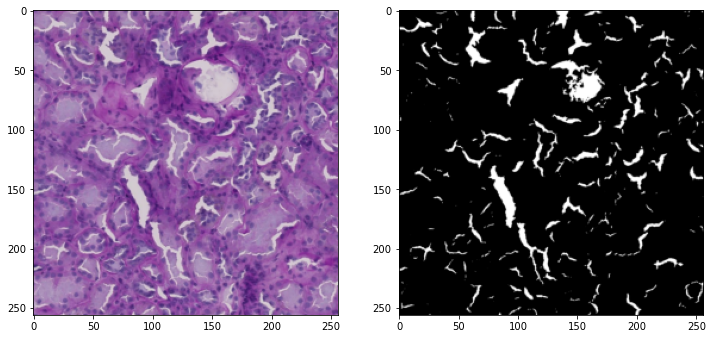

In [7]:
path_to_crops = out_path_to_light_crop.glob(f'*{path_to_imgs[0].stem}*{path_to_imgs[0].suffix}')
plt.rcParams["figure.figsize"] = (12,6)

del_mem_paths = []

def delete(light_crop, nothing):
    if light_crop not in del_mem_paths:
        del_mem_paths.append(light_crop)
        print("Added")
    
def f(nothing):
    clear_output(wait=True)
    display(button)
    
    try:
        
        path_to_light_crop = next(path_to_crops)
        print(path_to_light_crop)
        
        display(button_del)
        button_del._click_handlers.callbacks = []
        button_del.on_click(functools.partial(delete, str(path_to_light_crop)))
        
        dt_crop_with_light = TFReader(path_to_light_crop)
        crop_with_light = dt_crop_with_light.read()
        
        mask = crop_with_light[3]
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(crop_with_light[:3].transpose([1, 2, 0]), cmap='gray')
        ax2.imshow(mask, cmap='gray')
        plt.show()

        del dt_crop_with_light

    except StopIteration:
        print("ATTENTION: DELETE IMAGES")

    
button = widgets.Button(description="Next")
button_del = widgets.Button(description="Delete")

display(button)
button.on_click(f)

#### Delete

In [ ]:
print(f'{len(np.unique(del_mem_paths))} crops will be removed')

In [ ]:
print(f'{len(np.unique(del_mem_paths))} crops has been removed')
for path in del_mem_paths:
    Path(path).unlink(missing_ok=True)

#### Crop rgb by mask

In [ ]:
# path_to_crops = out_path_to_light_crop.glob(f'*{path_to_imgs[0].suffix}')
# for path_to_light_crop in path_to_crops:
#     print(path_to_light_crop)
#     dt_crop_with_light = RasterioReader(path_to_light_crop)
#     crop_with_light_mask = dt_crop_with_light.read()

#     rgb = crop_with_light_mask[:3]
#     mask = crop_with_light_mask[3]
#     crop_with_light_mask[:3] = rgb * (mask//255)
#     del  dt_crop_with_light
#     utils.save_arr_as_tiff(crop_with_light_mask, path_to_light_crop)